## K-Means Clustering on Frailty
#### By Gavin Qu, Aug 11th 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
df = pd.read_csv('/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_long_panel.csv')

In [11]:
df.head(2)

,pidp,age_dv,disdif1,disdif2,disdif3,disdif4,disdif5,disdif6,disdif7,disdif8,...,healthcond9,healthcond10,healthcond11,healthcond12,healthcond13,healthcond14,healthcond15,healthcond16,death,frailty
0,22445,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.037037
1,22445,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.037037


In [9]:
df_frailty = df[['pidp', 'wave', 'age_dv', 'death', 'frailty']]
df_frailty.head(2)

,pidp,wave,age_dv,death,frailty
0,22445,d,27.0,0,0.037037
1,22445,e,28.0,0,0.037037


In [10]:
df_frailty.describe()

,pidp,age_dv,death,frailty
count,5.379200e+05,537888.000000,537920.000000,529303.000000
mean,7.789122e+08,48.326057,0.008261,0.057325
std,4.651049e+08,18.842408,0.090516,0.116342
min,2.244500e+04,0.000000,0.000000,0.000000
25%,4.080830e+08,33.000000,0.000000,0.000000
50%,7.483869e+08,48.000000,0.000000,0.037037
75%,1.157245e+09,63.000000,0.000000,0.074074
max,1.653277e+09,105.000000,1.000000,1.000000


In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### K-means Implementation
We will treat health trajectory of each person over the clustering period as a vector, then remove those with NaN values.

In [15]:
# Filter data for ages 50 to 60
df_filtered = df_frailty[(df_frailty['age_dv'] >= 50) & (df_frailty['age_dv'] <= 60)]

# Create health trajectory vectors
def create_health_vector(group):
    return [group.get(age, np.nan) for age in range(50, 61, 2)] # step size = 2 as in the slides

health_trajectories = df_filtered.groupby('pidp').apply(
    lambda x: create_health_vector(x.set_index('age_dv')['frailty'].to_dict())
).tolist()

# Remove any trajectories with NaN values
health_trajectories = [h for h in health_trajectories if not any(np.isnan(h))]

# Convert to numpy array
X = np.array(health_trajectories)

X_scaled = X # no need to normalize here

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_94427/2456218756.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  health_trajectories = df_filtered.groupby('pidp').apply(


In [16]:
def kmeans_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    return kmeans

#### Elbow Method
The elbow method plot shows the relationship between the number of clusters (k) and the inertia (within-cluster sum of squares). Here's how to interpret it:
1) Look for an "elbow" point in the plot where the rate of decrease sharply changes.
2) This point represents a good balance between cluster coherence and number of clusters.
3) After this point, adding more clusters doesn't significantly reduce inertia.

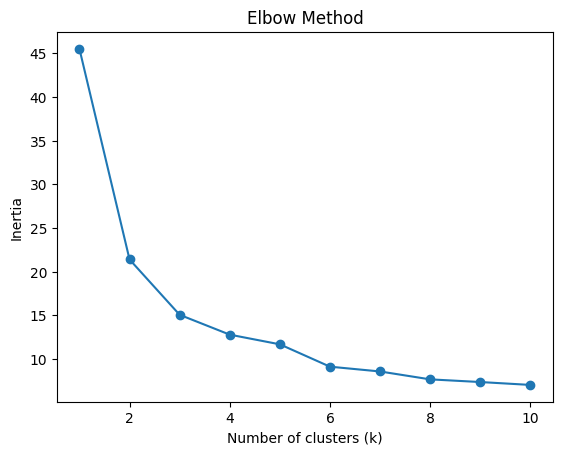

In [17]:
def elbow_method(X, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = kmeans_clustering(X, k)
        inertias.append(kmeans.inertia_)
    
    plt.plot(range(1, max_clusters + 1), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()

elbow_method(X_scaled)

#### Silhouette Method
The silhouette method measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where higher values indicate better-defined clusters. 

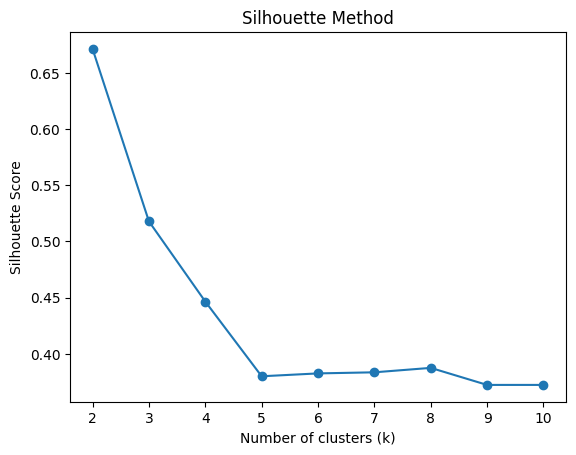

In [18]:
def silhouette_method(X, max_clusters=10):
    silhouette_scores = []
    for k in range(2, max_clusters + 1):  # Start from 2 clusters
        kmeans = kmeans_clustering(X, k)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
    
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')
    plt.show()

silhouette_method(X_scaled)